## GRU using IMDB dataset

In [1]:
import tensorflow as tf
print(tf.__version__)


2.4.0


In [ ]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


In [3]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [4]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

### GRU modeling


In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [7]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/50
782/782 [==============================] - 24s 19ms/step - loss: 0.6230 - accuracy: 0.6189 - val_loss: 0.3871 - val_accuracy: 0.8320
Epoch 2/50
782/782 [==============================] - 14s 18ms/step - loss: 0.3083 - accuracy: 0.8746 - val_loss: 0.3576 - val_accuracy: 0.8399
Epoch 3/50
782/782 [==============================] - 14s 18ms/step - loss: 0.2378 - accuracy: 0.9102 - val_loss: 0.4094 - val_accuracy: 0.8383
Epoch 4/50
782/782 [==============================] - 14s 18ms/step - loss: 0.1930 - accuracy: 0.9292 - val_loss: 0.3911 - val_accuracy: 0.8372
Epoch 5/50
782/782 [==============================] - 14s 18ms/step - loss: 0.1503 - accuracy: 0.9482 - val_loss: 0.4373 - val_accuracy: 0.8231
Epoch 6/50
782/782 [==============================] - 14s 18ms/step - loss: 0.1257 - accuracy: 0.9582 - val_loss: 0.5019 - val_accuracy: 0.8185
Epoch 7/50
782/782 [==============================] - 14s 18ms/step - loss: 0.0964 - accuracy: 0.9708 - val_loss: 0.5014 - val_accuracy:

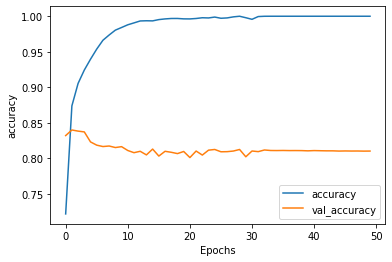

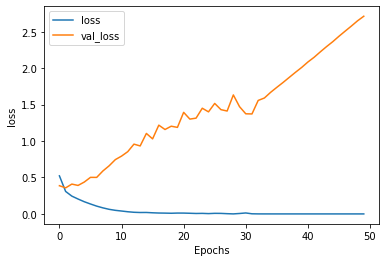

In [8]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### Another model define
LSTM이랑 Convolution model define하는 방법 차이 보기

In [ ]:
# Model Definition with LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


In [ ]:
# Model Definition with Conv1D
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


### 참고
NLP는 CV보다 오버피팅이 잘 일어난다. 이미지랑은 달리 대부분의 validation set의 단어들은 처음보는 단어이기 때문(?)
* Remember with text, you'll probably get a bit more overfitting than you would have done with images.
* Not least because you'll almost always have out of vocabulary words in the validation data set.